# Ordered phases in rydberg systems

In this example notebook, we will introduce the ordered phases in Rydberg systems, focusing on the 1D $Z_2$ phase and the 2D checkerboard phase. These many-body ground states can be prepared via adiabatic evolution of the Rydberg systems.

## Adiabatic evolution

The adiabatic theorem is a well-known concept from quantum mechanics, which states that 

>A physical system will remains in its *instantaneous* eigenstate if the system evolves slowly enough such that the transition between the eigenstate and the rest of the states of system is negligible.

This will play a key role in preparing the desired many-body ground states in the Rydberg system. Recall that the Rydberg Hamiltonian takes the following form
\begin{align}
H(t) = \sum_{k=1}^N \frac{\Omega(t)}{2}\left(|g_k\rangle\langle r_k| + |r_k\rangle\langle g_k|\right) - \Delta_\text{global}(t){n}_k + \sum_{j<k}V_{jk}{n}_j{n}_k,
\end{align}
where, for simplicity, we set the phase and the shifting field to be zero in this notebook. As we have seen in previous notebooks, the Rabi frequency starts from zero ($\Omega(t=0)=0$), hence with negative detuning ($\Delta_\text{global}(t=0)<0$), all the atoms in the system will tend to stay in the ground states with $n_k\equiv|g_k\rangle\langle g_k|=0$. This will also be the initial state of our analog Hamiltonian simulation (AHS) programs, hence the evolution starts from an eigenstate (the ground state) of the system.

In order to arrive at the target Hamiltonian, we turn on the Rabi frequency, and ramping up the detuning strength from negative to positive. If the process is slow enough, by the adiabatic theorem, the system approximately remains in the ground state throughout the evolution. 

At the end of the AHS program, the Rabi frequency will be turn off and since $\Delta_\text{global}>0$, all the atoms tend to stay in the Rydberg state. However, due to the strong Rydberg interaction, within the blockade radius, only one atom can be excited to the Rydberg state. Suppose we adjust the separation between the atoms such that only neighboring atoms are within the blockade radius, we will arrive at the so called $Z_2$ phase for 1D chain (with odd number of sites) and the checkerboard phase for 2D array  (with odd number of sites). The common feature of these phases is that the atoms are excited to the Rydberg states in an alternative pattern, complying to the blockade constraint, as shown in the figure below.

![blockade_example.png](blockade_example.png)

We will realize these phases in this notebook. To begin, we import the necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from braket.ahs.atom_arrangement import AtomArrangement

from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from utils import show_register, show_global_drive, show_final_avg_density, get_drive

from braket.devices import LocalSimulator

## 1D $Z_2$ phase 

Here we consider a 1D chain of 9 atoms with neighboring atoms separated by $5.5\mu m$. The setup of the system can be generated as follows

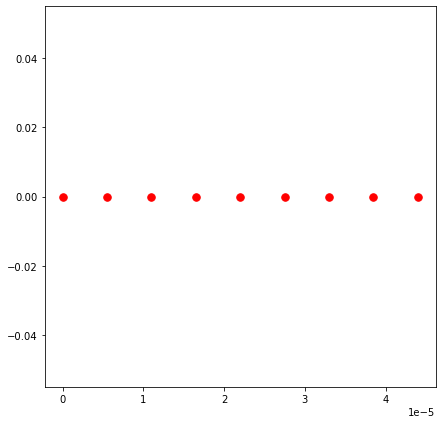

In [2]:
register = AtomArrangement()
separation = 5.5e-6  # in meters 
num_atoms = 9

for k in range(num_atoms):
    register.add((k*separation, 0))
    
show_register(register)

In order to prepare the $Z_2$ ordered state for the atomic chain, we shall design an AHS program that drives the system adiabatically. As described above, we start from $\Omega(t=0)=0$ with $\Delta(t=0)<0$, followed by turning on $\Omega(t)$ and ramping up $\Delta(t). We will turn off the Rabi frequency at the end of the program. The program can be specified as follows.

In [4]:
amplitude_min = 0       
amplitude_max = 6.3e6
detuning_min = -6e6
detuning_max = 15e6

time_max = 4e-6
time_ramp = 5e-7

time_points = [0, time_ramp, time_max - time_ramp, time_max]
amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]


drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)

We can plot the waveforms of these driving fields to make sure that they are correctly specified.

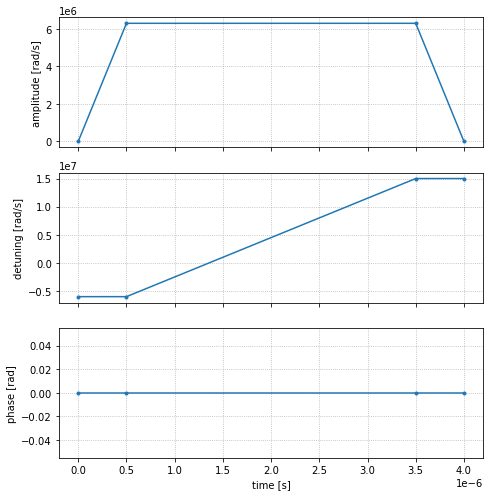

In [4]:
show_global_drive(drive)

Finally the AHS program of interest is the collection of the atomic registers, and the Hamiltonian defined above. 

In [5]:
ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)


Before runnig the program on Quera's device, we can first run it on the local simulator to make sure the outcome is the expected $Z_2$ state. 

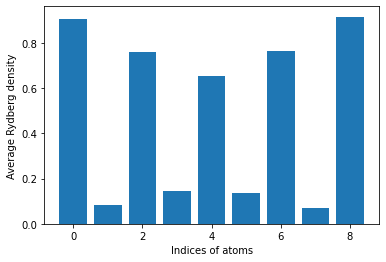

In [72]:
device = LocalSimulator("braket_ahs")
result = device.run(ahs_program, shots=1000).result()
show_final_avg_density(result)

The $Z_2$ phase can be characterized by the density correlation function $g_{ij}$ between the $i$-th and the $j$-th atom, which is defined as
\begin{align}
g_{ij} = \langle n_in_j\rangle - \langle n_i\rangle\langle n_j\rangle
\end{align}
where $\langle\cdot\rangle$ is the average over the shots.

In [74]:
def get_correlation_Z2(result):
    
    post_sequences = [list(measurement.post_sequence) for measurement in result.measurements]
    
    freqs, confs = [], []
    for post_sequence in post_sequences:
        if post_sequence in confs:
            index = confs.index(post_sequence)
            freqs[index] += 1
        else:
            confs.append(post_sequence)
            freqs.append(1)
            
    freqs = np.array(freqs)/len(post_sequences)
    confs = 1 - np.array(confs) # change the notation such 1 for rydberg state, and 0 for ground state
    
    n = np.sum([conf * freq for conf, freq in zip(confs, freqs)], axis=0)
    
    gij = [[0 for _ in range(num_atoms)] for _ in range(num_atoms)]
    
    for i in range(num_atoms):
        for j in range(num_atoms):
            cov = -1 * n[j] * n[i]
            for kk in range(len(freqs)):            
                cov += freqs[kk] * confs[kk][j] * confs[kk][i] 
            gij[i][j] = cov    
    
    return gij

gij = get_correlation_Z2(result)

The density correlation function can be visualized as follows.

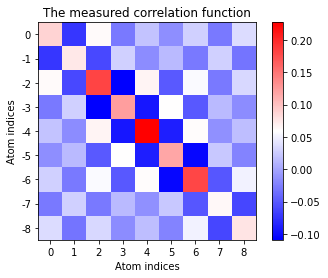

In [75]:
plt.imshow(gij, cmap='bwr')
plt.xticks(range(num_atoms), [f'{i}' for i in range(num_atoms)])
plt.xlabel("Atom indices")
plt.yticks(range(num_atoms), [f'{-j}' for j in range(num_atoms)])
plt.ylabel("Atom indices")
plt.title('The measured correlation function')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()


For more explanation and interpretation of the density correlation functions, we refer readers to other references, for example, *Probing many-body dynamics on a 51-atom quantum simulator* by [Bernien et al.](https://arxiv.org/abs/1707.04344). 

## 2D checkerboard phase 

In two dimension, Rydberg system can exhibit the checkerboard phase, which is analogues to the $Z_2$ phase in 1D. For simplicity, here we create a $3\times 3$ square lattice.

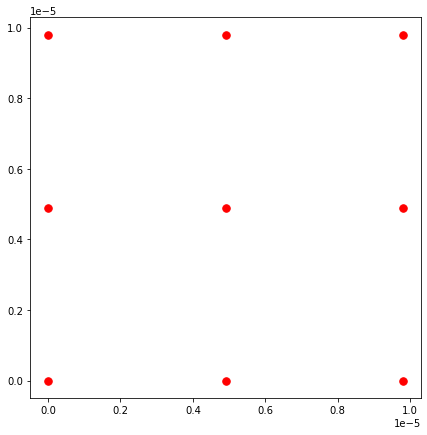

In [4]:
register_2D = AtomArrangement()
separation = 4.9e-6  # in meters 

for k in range(3):
    for l in range(3):
        register_2D.add((k * separation, l * separation))

show_register(register_2D)

The driving field is similar to the one for generating the $Z_2$ phase, with slight modifications for the parameters. 

In [79]:
amplitude_min = 0       
amplitude_max = 6.3e6 # good

detuning_min = -3e6
detuning_max = 10e6

time_max = 4e-6
time_ramp = 10e-7

time_points = [0, time_ramp, time_max - time_ramp, time_max]
amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]


drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)


Finally we assemble the 2D array with the driving field, and run the AHS program on the local simulator.

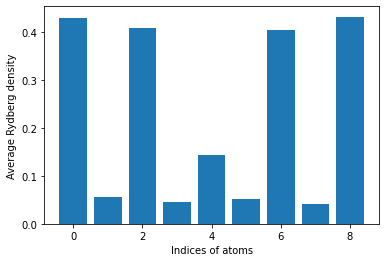

In [78]:
ahs_program_2D = AnalogHamiltonianSimulation(
    register=register_2D, 
    hamiltonian=drive
)

result_2D = device.run(ahs_program_2D, shots=1000, steps=200).result()
show_final_avg_density(result_2D)

Some comments

## Realizing $Z_2$ and checkerboard phase on a QPU